In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## Загрузите набор данных banknote.txt. Необходимо решить задачу классификации подлинности банкнот (предсказать переменную class).

In [2]:
data = pd.read_csv('banknote.txt', sep=',')
print(data)

      variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]


### Выполните предварительную обработку данных.

#### Основные данные о датасете

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


#### Обработка пропущенных значений

In [5]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Нет пропущенных значений

#### Обработка выбросов

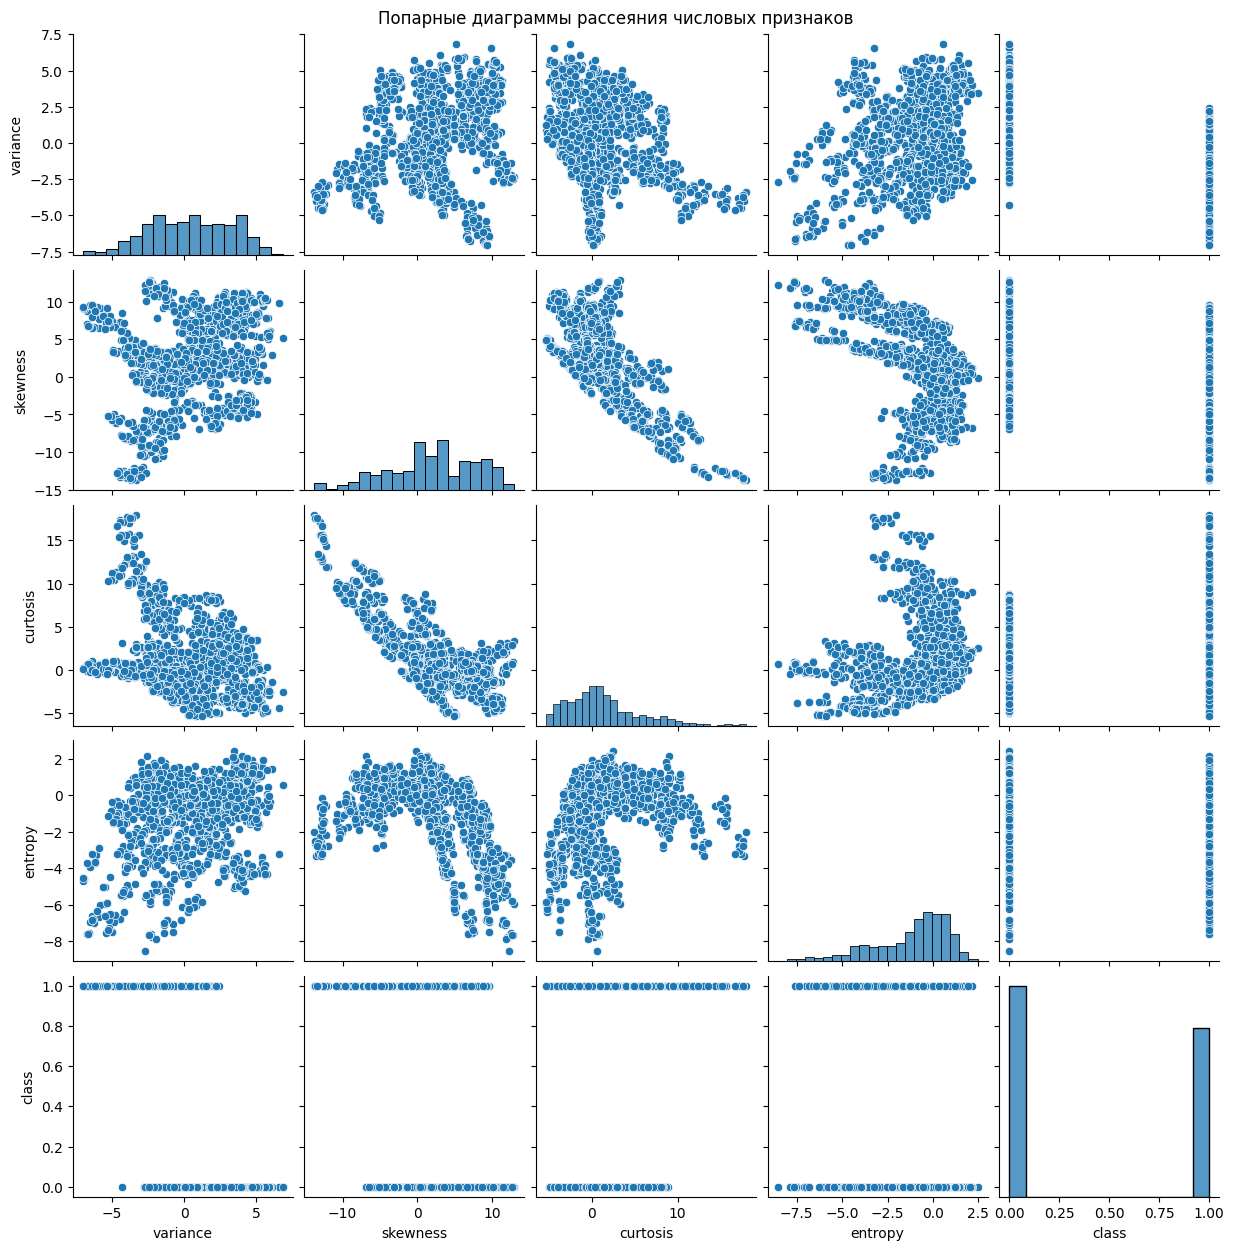

In [6]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(data[numeric_cols])
plt.suptitle("Попарные диаграммы рассеяния числовых признаков", y=1)
plt.show()

Используем межквартильный размах

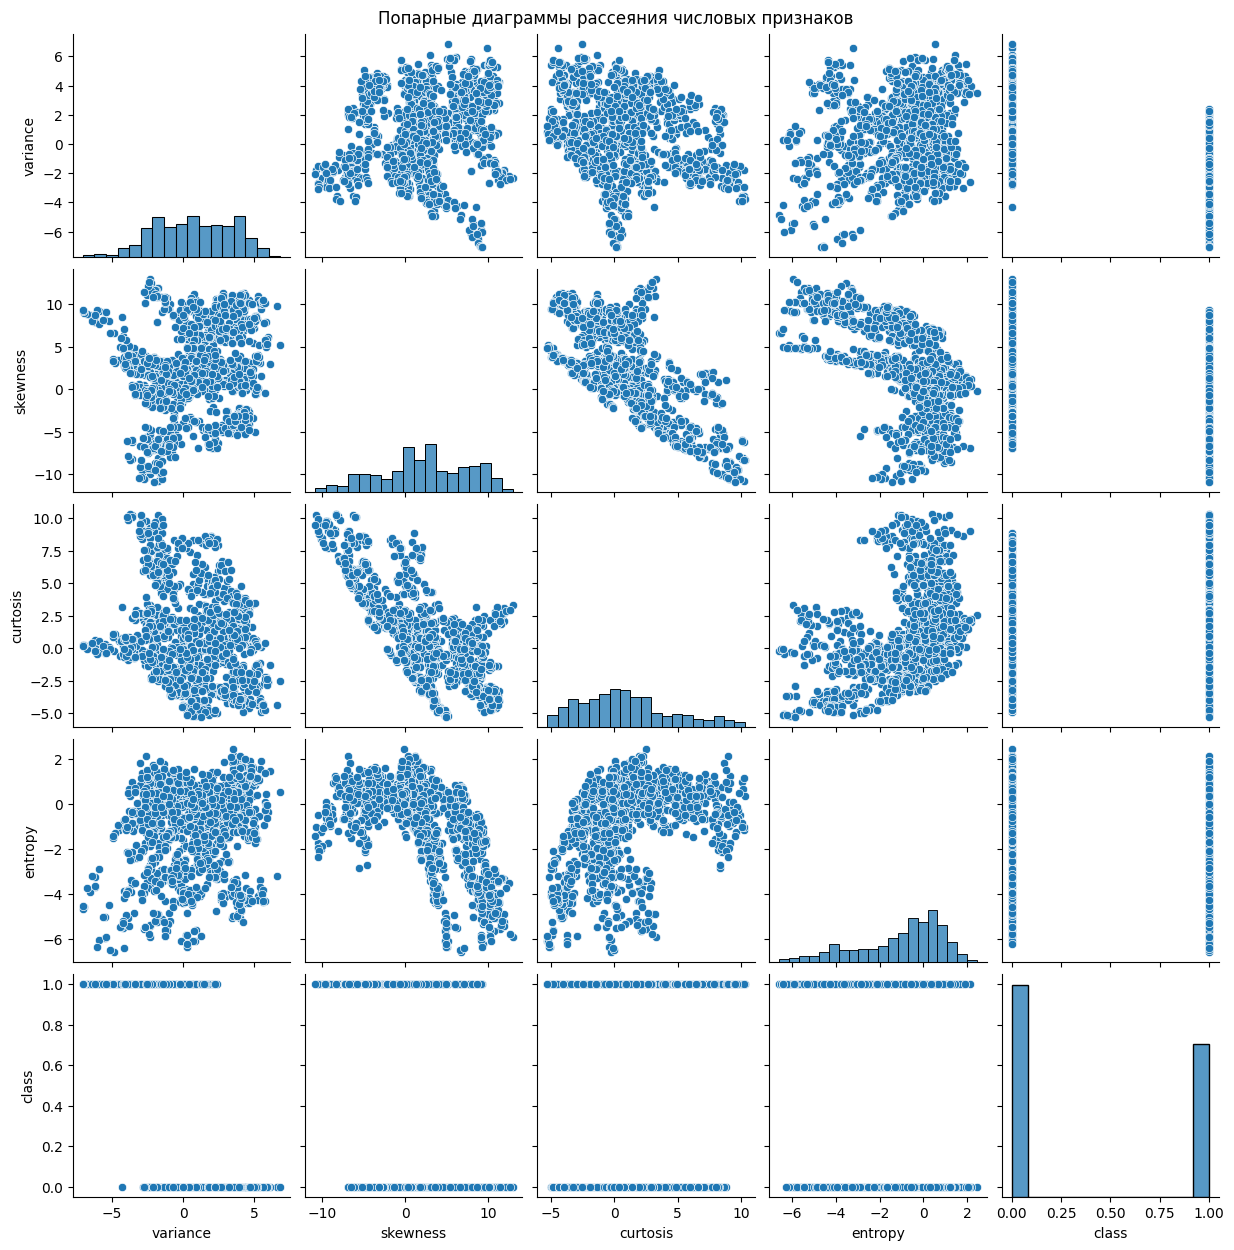

In [7]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data = remove_outliers_iqr(data, 'variance')
data = remove_outliers_iqr(data, 'skewness')
data = remove_outliers_iqr(data, 'curtosis')
data = remove_outliers_iqr(data, 'entropy')
data = remove_outliers_iqr(data, 'class')

sns.pairplot(data[numeric_cols])
plt.suptitle("Попарные диаграммы рассеяния числовых признаков", y=1)
plt.show()

#### Нормировка

In [8]:
for col in numeric_cols:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

data

,variance,skewness,curtosis,entropy,class
0,0.769004,0.820084,0.159006,0.679130,0.0
1,0.835659,0.799148,0.181374,0.566678,0.0
2,0.786629,0.345498,0.462516,0.740440,0.0
3,0.757105,0.856051,0.081780,0.330464,0.0
4,0.531578,0.269221,0.632350,0.619109,0.0
...,...,...,...,...,...
1363,0.423700,0.396490,0.526656,0.801893,1.0
1366,0.334040,0.613413,0.313289,0.585156,1.0
1367,0.537124,0.512903,0.246066,0.666668,1.0
1368,0.407690,0.251500,0.754588,0.766510,1.0


### Отбор признаков, разделение на выборки

In [9]:
X = data[['variance', 'skewness', 'curtosis', 'entropy']] 
y = data['class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(958, 320)

### Random Forest

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # Количество деревьев в лесу
    'max_depth': [None, 5, 10],       # Максимальная глубина дерева (None - без ограничений)
    'min_samples_split': [2, 5, 10], # Минимальное количество выборок, необходимое для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4]   # Минимальное количество выборок, необходимое для листового узла
}

In [13]:
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='accuracy', verbose=2)

In [14]:
best_rf_model = grid_search.best_estimator_

На обучающей выборке

In [15]:
y_train_pred = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

На тестовой выборке

In [16]:
y_test_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

На обучающей выборке с использованием кросс-валидации

In [17]:
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

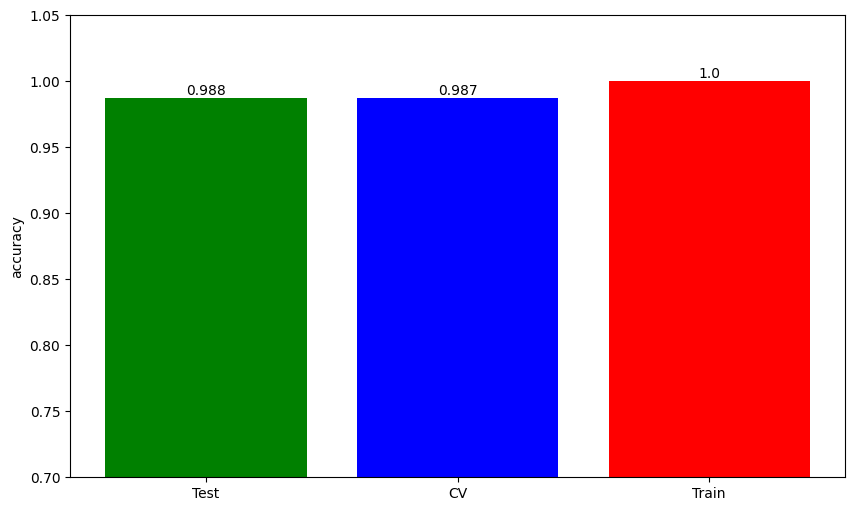

In [18]:
model_names = ['Test', 'CV', 'Train']
accuracies = [test_accuracy, cv_scores.mean(), train_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.ylabel('accuracy')
plt.ylim(0.7, 1.05)
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 3), ha='center', va='bottom')
plt.show()

### Логистическая регрессия

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Параметр регуляризации
    'penalty': ['l1', 'l2'],  # Тип регуляризации (L1 или L2)
    'solver': ['liblinear', 'saga']  # Алгоритм оптимизации (подходит для небольших датасетов и L1 регуляризации)
}

In [21]:
model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5) # cv=5 означает 5-fold кросс-валидацию
grid_search.fit(X_train, y_train)

C:\Users\serez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\serez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\serez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\serez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: Conve

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [22]:
best_model = grid_search.best_estimator_

На обучающей выборке

In [23]:
train_accuracy = best_model.score(X_train, y_train)

На тестовой выборке

In [24]:
test_accuracy = best_model.score(X_test, y_test)

На обучающей выборке с использованием кросс-валидации

In [25]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

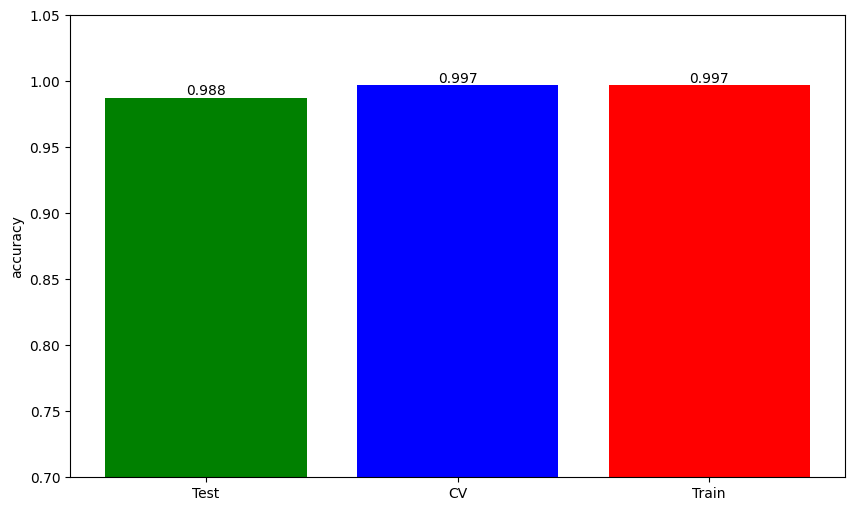

In [26]:
model_names = ['Test', 'CV', 'Train']
accuracies = [test_accuracy, cv_scores.mean(), train_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.ylabel('accuracy')
plt.ylim(0.7, 1.05)
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 3), ha='center', va='bottom')
plt.show()

### Алгоритм k ближайших соседей

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Количество соседей
    'weights': ['uniform', 'distance'],  # Взвешивание соседей (одинаково или по расстоянию)
    'p': [1, 2]  # Расстояние Минковского: 1 - манхэттенское, 2 - евклидово
}

In [29]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5) # cv=5 означает 5-fold кросс-валидацию
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [30]:
best_knn = grid_search.best_estimator_

На обучающей выборке

In [31]:
train_accuracy = best_knn.score(X_train, y_train)

На тестовой выборке

In [32]:
test_accuracy = best_knn.score(X_test, y_test)

На обучающей выборке с использованием кросс-валидации

In [33]:
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='accuracy')

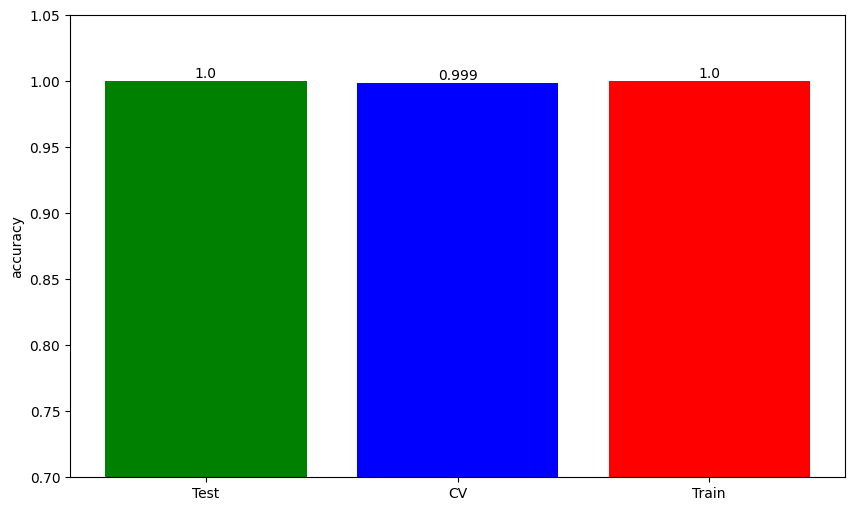

In [34]:
model_names = ['Test', 'CV', 'Train']
accuracies = [test_accuracy, cv_scores.mean(), train_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.bar(model_names, accuracies, color=['green', 'blue', 'red'])
plt.ylabel('accuracy')
plt.ylim(0.7, 1.05)
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 3), ha='center', va='bottom')
plt.show()

### Вычисление всех метрик для kNN

In [40]:
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1] # вероятности для класса 1

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
AUC-ROC: 1.0000
Confusion Matrix:
 [[189   0]
 [  0 131]]


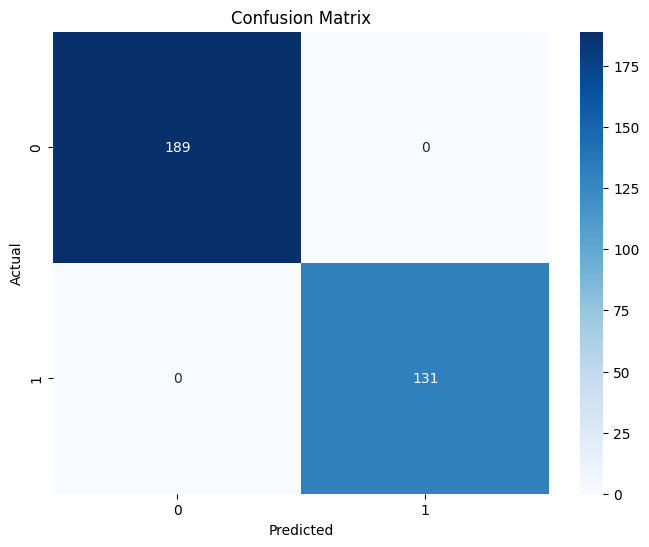

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

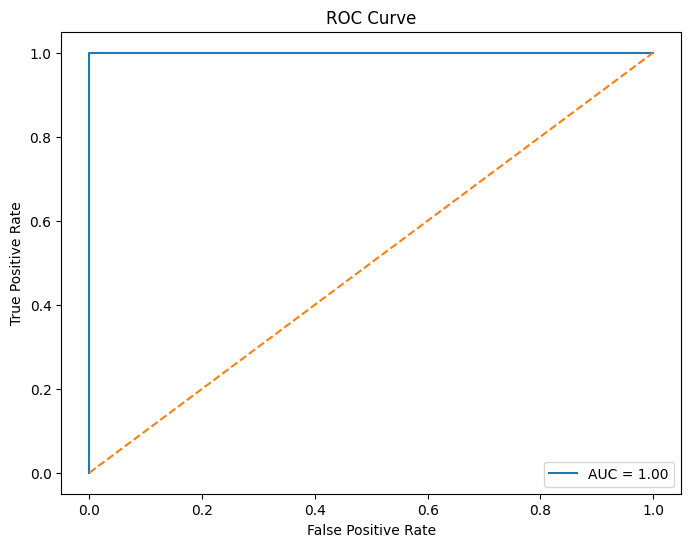

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()